Skip the first two steps if you've already ran them and simply need to continue downloading images

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import math
import random
import os
import numpy as np
import pandas as pd
from osgeo import gdal, osr
from tqdm.notebook import tqdm
import requests
import matplotlib.pyplot as plt
from io import BytesIO
import logging
import time

In [ ]:
BASE_DIR = 'gdrive/MyDrive/geo'
COUNTRIES_DIR = os.path.join(BASE_DIR, 'data', 'countries')
PROCESSED_DIR = os.path.join(BASE_DIR, 'data', 'processed')
# can try using the google downloader, in which case change this to be your google api token
ACCESS_TOKEN_DIR = os.path.join(BASE_DIR, 'planet_api_key.txt')

RANDOM_SEED = 7 # for reproducibility

# each cluster must have AT LEAST this many images after doing nightlights processing
MIN_IMAGES_PER_CLUSTER = 10

In [ ]:
# from ctypes.util import find_library
# find_library('geos_c')
import sys
sys.path.append(BASE_DIR)
from utils import create_space

# Generate Download Locations

In [ ]:
# # df_mw = pd.read_csv(os.path.join(COUNTRIES_DIR, 'malawi_2016', 'processed/clusters.csv'))
# df_eth = pd.read_csv(os.path.join(COUNTRIES_DIR, 'ethiopia_2015', 'processed/clusters.csv'))
df_ng = pd.read_csv(os.path.join(COUNTRIES_DIR, 'nigeria_2015', 'processed/clusters.csv'))

In [ ]:
for country in ['malawi_2016', 'ethiopia_2015', 'nigeria_2015']:
    os.makedirs(os.path.join(COUNTRIES_DIR, country, 'images'), exist_ok=False)

FileExistsError: ignored

In [ ]:
def generate_download_locations(df, ipc=50):
    '''
    Takes a dataframe with columns cluster_lat, cluster_lon
    Generates a 10km x 10km bounding box around the cluster and samples 
    ipc images per cluster. First samples in a grid fashion, then any 
    remaining points are randomly (uniformly) chosen
    '''
    np.random.seed(RANDOM_SEED) # for reproducability
    df_download = {'image_name': [], 'image_lat': [], 'image_lon': [], 'cluster_lat': [], 
                   'cluster_lon': [], 'cons_pc': [], 'schools': [] }
    
    # side length of square for uniform distribution
    edge_num = math.floor(math.sqrt(ipc))
    for _, r in df.iterrows():
        min_lat, min_lon, max_lat, max_lon = create_space(r.cluster_lat, r.cluster_lon)
        lats = np.linspace(min_lat, max_lat, edge_num).tolist()
        lons = np.linspace(min_lon, max_lon, edge_num).tolist()

        # performs cartesian product
        uniform_points = np.transpose([np.tile(lats, len(lons)), np.repeat(lons, len(lats))])
        
        lats = uniform_points[:,0].tolist()
        lons = uniform_points[:,1].tolist()
        
        # fills the remainder with random points
        for _ in range(ipc - edge_num * edge_num):
            lat = random.uniform(min_lat, max_lat)
            lon = random.uniform(min_lon, max_lon)
            lats.append(lat)
            lons.append(lon)
        
        # add to dict
        for lat, lon in zip(lats, lons):
            # image name is going to be image_lat_image_lon_cluster_lat_cluster_lon.png
            image_name = str(lat) + '_' + str(lon) + '_' + str(r.cluster_lat) + '_' + str(r.cluster_lon) + '.png'
            df_download['image_name'].append(image_name)
            df_download['image_lat'].append(lat)
            df_download['image_lon'].append(lon)
            df_download['cluster_lat'].append(r.cluster_lat)
            df_download['cluster_lon'].append(r.cluster_lon)
            df_download['cons_pc'].append(r.cons_pc)
            df_download['schools'].append(r.schools)
        
    return pd.DataFrame.from_dict(df_download)

In [ ]:
# # df_mw_download = generate_download_locations(df_mw)
# df_eth_download = generate_download_locations(df_eth)
df_ng_download = generate_download_locations(df_ng)

In [ ]:
# df_mw_download.shape, df_eth_download.shape, df_ng_download.shape
df_ng_download.shape

(33000, 7)

In [ ]:
# df_mw_download.head()

In [ ]:
# df_eth_download.head()

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,cons_pc,nightlights
0,3.410784802784024_39.47107816189403_3.45570056...,3.410785,39.471078,3.455701,39.515994,14.854634,0.0
1,3.4257567241860163_39.47107816189403_3.4557005...,3.425757,39.471078,3.455701,39.515994,14.854634,0.0
2,3.440728645588008_39.47107816189403_3.45570056...,3.440729,39.471078,3.455701,39.515994,14.854634,0.0
3,3.45570056699_39.47107816189403_3.45570056699_...,3.455701,39.471078,3.455701,39.515994,14.854634,0.0
4,3.470672488391992_39.47107816189403_3.45570056...,3.470672,39.471078,3.455701,39.515994,14.854634,0.0


In [ ]:
df_ng_download.head()

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,cons_pc,schools
0,4.270870351534024_6.223837135554024_4.31578611...,4.270870,6.223837,4.315786,6.268753,0.0,0
1,4.285842272936016_6.223837135554024_4.31578611...,4.285842,6.223837,4.315786,6.268753,0.0,0
2,4.300814194338008_6.223837135554024_4.31578611...,4.300814,6.223837,4.315786,6.268753,0.0,0
3,4.31578611574_6.223837135554024_4.31578611574_...,4.315786,6.223837,4.315786,6.268753,0.0,0
4,4.330758037141992_6.223837135554024_4.31578611...,4.330758,6.223837,4.315786,6.268753,0.0,0


In [ ]:
# # df_mw_download['country'] = 'mw'
# df_eth_download['country'] = 'eth'
df_ng_download['country'] = 'ng'

In [ ]:
# for image download purposes the country distinction is irreleveant
# df_potential_download = pd.concat([df_mw_download, df_eth_download, df_ng_download], axis=0)
df_potential_download = df_ng_download
df_potential_download.reset_index(drop=True, inplace=True)

In [ ]:
df_potential_download.head()

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,cons_pc,schools,country
0,4.270870351534024_6.223837135554024_4.31578611...,4.270870,6.223837,4.315786,6.268753,0.0,0,ng
1,4.285842272936016_6.223837135554024_4.31578611...,4.285842,6.223837,4.315786,6.268753,0.0,0,ng
2,4.300814194338008_6.223837135554024_4.31578611...,4.300814,6.223837,4.315786,6.268753,0.0,0,ng
3,4.31578611574_6.223837135554024_4.31578611574_...,4.315786,6.223837,4.315786,6.268753,0.0,0,ng
4,4.330758037141992_6.223837135554024_4.31578611...,4.330758,6.223837,4.315786,6.268753,0.0,0,ng


In [ ]:
df_potential_download.shape

(33000, 8)

# Filter Download Choices

In [ ]:
df_potential_download['schools'].max()

576

In [ ]:
# most nightlights are 0
# let's download images that have nonzero nightlights to induce variety into the model
print((df_potential_download['schools'] == 0).mean())
print((df_potential_download['schools'] <= 2).mean())

0.3515151515151515
0.353030303030303


In [ ]:
def drop_0s(df, fr=0.1):
    """
        Solves for d:
            (c_z - d)/(n - d) = fr
        Where d = rows to drop, c_z = num rows with zero nightlights, n = num rows, fr = frac remaining
        
        Yields:
        d = (c_z - n*fr) / (1 - fr)
    """
    np.random.seed(RANDOM_SEED)
    c_z = (df['schools']==0).sum()
    n = len(df)
    assert c_z / n > fr, print(f'Dataframe already has under {fr} zeros')
    
    d = (c_z - n * fr) / (1 - fr)
    d = int(d)
    print(f'dropping: {d}')
    
    zero_df = df[df['schools']==0]
    zero_clusters = zero_df.groupby(['cluster_lat', 'cluster_lon'])
    per_cluster_drop = int(d / len(zero_clusters))
    print(f'Need to drop {per_cluster_drop} per cluster with 0 nightlights')
    
    drop_inds = []
    for (cluster_lat, cluster_lon), group in zero_clusters:
        z_inds = group.index
        clust_drop = np.random.choice(z_inds, per_cluster_drop, replace=False)
        assert len(group) - len(clust_drop) >= MIN_IMAGES_PER_CLUSTER, print(f'dropping too many in {cluster_lat}, {cluster_lon}')
        drop_inds += clust_drop.tolist()
    
    # this is how you do it purely randomly but some clusters might get wiped out
    # z_inds = np.argwhere(df['nightlights'].values == 0).reshape(-1)
    # drop_inds = np.random.choice(z_inds, d, replace=False)
    return df.drop(drop_inds).reset_index(drop=True)

def drop_in_range(df, lower=0, upper=2, fr=0.25):
    """
        Very similar to drop_0s calculation, but more generalized. Lower and upper are inclusive.
    """
    np.random.seed(RANDOM_SEED)
    boolean_idx = ((lower <= df['schools']) & (df['schools'] <= upper))
    c_under = boolean_idx.sum()
    n = len(df)
    assert c_under / n > fr, print(f'Dataframe already has under {fr} rows in the given range')
    
    d = (c_under - n * fr) / (1 - fr)
    d = int(d)
    print(f'dropping: {d}')
    
    select_df = df[boolean_idx]
    select_clusters = select_df.groupby(['cluster_lat', 'cluster_lon'])
    per_cluster_drop = int(d / len(select_clusters))
    print(f'Need to drop {per_cluster_drop} per cluster in the given range')
    
    drop_inds = []
    for (cluster_lat, cluster_lon), group in select_clusters:
        z_inds = group.index
        clust_drop = np.random.choice(z_inds, per_cluster_drop, replace=False)
        assert len(group) - len(clust_drop) >= MIN_IMAGES_PER_CLUSTER, print(f'dropping too many in {cluster_lat}, {cluster_lon}')
        drop_inds += clust_drop.tolist()
        
    return df.drop(drop_inds).reset_index(drop=True)


In [ ]:
df_mod_download = drop_0s(df_potential_download, fr=0.1)

dropping: 9222
Need to drop 39 per cluster with 0 nightlights


In [ ]:
df_potential_download.count()

image_name     33000
image_lat      33000
image_lon      33000
cluster_lat    33000
cluster_lon    33000
cons_pc        33000
schools        33000
country        33000
dtype: int64

In [ ]:
df_mod_download = df_potential_download
(df_mod_download['schools'] == 0).mean()

0.3515151515151515

In [ ]:
df_mod_download.min()

image_name     10.0028716514_8.833083927184022_10.0028716514_...
image_lat                                                4.27087
image_lon                                                2.83456
cluster_lat                                              4.31579
cluster_lon                                              2.87948
cons_pc                                                        0
schools                                                        0
country                                                       ng
dtype: object

In [ ]:
df_mod_download.max()

image_name     9.987899729998007_8.922915455595975_10.0028716...
image_lat                                                13.7592
image_lon                                                13.6756
cluster_lat                                              13.7142
cluster_lon                                              13.6307
cons_pc                                                  20.9519
schools                                                      576
country                                                       ng
dtype: object

In [ ]:
df_mod_download = drop_in_range(df_mod_download, lower=0, upper=576, fr=0.107)

dropping: 23951
Need to drop 36 per cluster in the given range
dropping too many in 4.31578611574, 6.26875289976


AssertionError: ignored

In [ ]:
((0.001 <= df_mod_download['schools']) & (df_mod_download['schools'] <= 3)).mean()

0.0020875083500334003

In [ ]:
# this has gone up now though
(df_mod_download['schools'] == 0).mean()

0.10654642618570474

In [ ]:
df_mod_download = drop_0s(df_mod_download, fr=0.2)

Dataframe already has under 0.2 zeros


AssertionError: ignored

At this point the low nightlight clusters (0 and under 3) have 11 and 12 images respectively, meaning very few more images can be dropped without going under 10.

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
X = df_mod_download['schools'].values.reshape(-1,1)
gmm = GMM(n_components=3).fit(X)
labels = gmm.predict(df_mod_download['schools'].values.reshape(-1,1))

In [ ]:
(labels==0).mean(), (labels==1).mean(), (labels==2).mean()

(0.7453239812959251, 0.029225116900467602, 0.22545090180360722)

In [ ]:
# these are the cutoff for the labels identified by the Guassian Mixture Model
label0_max = df_mod_download['schools'][labels==0].max()
label1_max = df_mod_download['schools'][labels==1].max()
label2_max = df_mod_download['schools'][labels==2].max()
label0_max, label1_max, label2_max

(68, 576, 240)

In [ ]:
# I am going to hand reassign these to have better representation among all three classes
# these are not ideal distributions obviously but the model should still be able to learn
# something like a quantile cut might work better and be less arbitrary, but for reproducability 
# purposes I'll stick to the GMM-based approach
label0_max = 0.05
label1_max = 5
label2_max = 70

In [ ]:
def query_df(df, lower, upper):
    return df[((lower <= df['schools']) & (df['schools'] < upper))]

print(len(query_df(df_mod_download, 0, label0_max)) / len(df_mod_download))
print(len(query_df(df_mod_download, label0_max, label1_max)) / len(df_mod_download))
print(len(query_df(df_mod_download, label1_max, label2_max)) / len(df_mod_download))

0.10654642618570474
0.0647127588510354
0.574064796259185


In [ ]:
def create_nightlights_bin(df, cutoffs):
    assert len(cutoffs) >= 2, print('need at least 2 bins')
    cutoffs = sorted(cutoffs, reverse=True)
    labels = list(range(len(cutoffs)))[::-1]
    df['schools_bin'] = len(cutoffs)
    for cutoff, label in zip(cutoffs, labels):
        df['schools_bin'].loc[df['schools'] <= cutoff] = label

df_download = df_mod_download.copy()
create_nightlights_bin(df_download, cutoffs=[label0_max, label1_max, label2_max])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

In [ ]:
# these should match above
(df_download['schools_bin']==0).mean(), (df_download['schools_bin']==1).mean(), (df_download['schools_bin']==2).mean()


(0.10654642618570474, 0.0647127588510354, 0.584502338009352)

In [ ]:
df_download.shape

(23952, 9)

In [ ]:
os.makedirs(PROCESSED_DIR, exist_ok=True)

In [ ]:
df_download.to_csv(os.path.join(PROCESSED_DIR, 'image_download_locs.csv'), index=False)

In [ ]:
df_download.count()

image_name     23952
image_lat      23952
image_lon      23952
cluster_lat    23952
cluster_lon    23952
cons_pc        23952
schools        23952
country        23952
schools_bin    23952
dtype: int64

# Download Images
If the script breaks, you can restart here by uncommenting the line below and running the below code again. It won't download images you have already downloaded.

In [ ]:
# df_download = pd.read_csv(os.path.join(PROCESSED_DIR, 'image_download_locs.csv'))

In [ ]:
# you can try the google downloader if you don't have the planet API key
# the tradeoff is that planet's data can be queried with time, but Google's images
# are higher res
from utils import PlanetDownloader

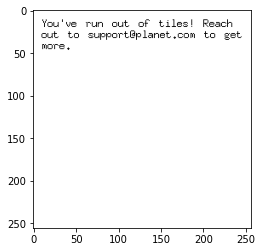

In [ ]:
# this demonstrates the API call
lat = 38.441332
lon = -105.234751
min_year = 2016
min_month = 1
max_year = 2016
max_month = 12

# access = open(ACCESS_TOKEN_DIR, 'r').readlines()[0].strip()
access = '9211d43783d34062be2a75640d8f7d6d'
pd = PlanetDownloader(access)
plt.imshow(pd.download_image(lat, lon, min_year, min_month, max_year, max_month))

In [ ]:
def download_images(df):
    """
    Download images using a pandas DataFrame that has "image_lat", "image_lon", "image_name", "country" as columns
    
    Saves images to the corresponding country's images folder

    To use the Google Downloader, switch PlanetDownloader to GoogleDownloader and make imd.download_image only
    provide lat and lon as arguments. Use zoom = 16.
    """
    access_list = ['9211d43783d34062be2a75640d8f7d6d','0e7c118039b34ce6b48b39f7a3623f98']
    g_count = 0
    
    num_retries = 20
    wait_time = 0.1 # seconds

    # drops what is already downloaded
    already_downloaded = os.listdir(os.path.join(COUNTRIES_DIR, 'malawi_2016', 'images')) + \
                        os.listdir(os.path.join(COUNTRIES_DIR, 'ethiopia_2015', 'images')) + \
                        os.listdir(os.path.join(COUNTRIES_DIR, 'nigeria_2015', 'images'))
    already_downloaded =  list(set(already_downloaded).intersection(set(df['image_name'])))
    print('Already downloaded ' + str(len(already_downloaded)))
    df = df.set_index('image_name').drop(already_downloaded).reset_index()
    print('Need to download ' + str(len(df)))
    # use three years of images to find one that matches search critera
    min_year = 2014
    min_month = 1
    max_year = 2016
    max_month = 12
    for i in range(len(access_list)):
      access = access_list[i]
      imd = PlanetDownloader(access)
      df_temp = df.iloc[i*10000:(i+1)*10000]
      for _, r in tqdm(df_temp.iterrows(), total=df_temp.shape[0]):
          if g_count > 10000:
            break
          g_count +=1
          lat = r.image_lat
          lon = r.image_lon
          zoom = 50
          name = r.image_name
          country_dir = None
          if r.country == 'mw':
              country_dir = 'malawi_2016'
          elif r.country == 'eth':
              country_dir = 'ethiopia_2015'
          elif r.country == 'ng':
              country_dir = 'nigeria_2015'
          else:
              print(f"unrecognized country: {r.country}")
              raise ValueError()
          image_save_path = os.path.join(COUNTRIES_DIR, country_dir, 'images', r.image_name)
          try:
              im = imd.download_image(lat, lon, min_year, min_month, max_year, max_month)
              if (type(im) == str and im == 'RETRY') or im is None:
                  resolved = False
                  for _ in range(num_retries):
                      time.sleep(wait_time)
                      im = imd.download_image(lat, lon, min_year, min_month, max_year, max_month)
                      if (type(im) == str and im == 'RETRY') or im is None:
                          continue
                      else:
                          plt.imsave(image_save_path, im)
                          resolved = True
                          break
                  if not resolved:
                      print(f'Could not download {lat}, {lon} despite several retries and waiting')
                      continue
                  else:
                      pass
              else:
                  # no issues, save according to naming convention
                  plt.imsave(image_save_path, im)

          except Exception as e:
              logging.error(f"Error-could not download {lat}, {lon}", exc_info=True)
              continue
        
    # with open(ACCESS_TOKEN_DIR, 'r') as f:
    #     access = f.readlines()[0]
    

In [ ]:
download_images(df_download)

Already downloaded 0
Need to download 23952


Could not download 4.31578611574, 6.223837135554024 despite several retries and waiting
Could not download 4.330758037141992, 6.223837135554024 despite several retries and waiting
Could not download 4.285842272936016, 6.238809056956016 despite several retries and waiting
Could not download 4.345729958543984, 6.253780978358008 despite several retries and waiting
Could not download 4.300814194338008, 6.26875289976 despite several retries and waiting
Could not download 4.330758037141992, 6.26875289976 despite several retries and waiting
Could not download 4.345729958543984, 6.313668663965976 despite several retries and waiting
Could not download 4.283803377034025, 6.263256104344025 despite several retries and waiting
Could not download 4.283803377034025, 6.278228025746017 despite several retries and waiting
Could not download 4.3287191412400015, 6.278228025746017 despite several retries and waiting
Could not download 4.313747219838009, 6.3081718685500014 despite several retries and waitin

ERROR:root:Error-could not download 4.358662984043986, 6.353087632755978
Traceback (most recent call last):
  File "<ipython-input-132-e8009a3609ec>", line 56, in download_images
    im = imd.download_image(lat, lon, min_year, min_month, max_year, max_month)
  File "gdrive/MyDrive/geo/utils/planet_downloader.py", line 95, in download_image
    res = json.loads(result.text)
  File "/usr/lib/python3.7/json/__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.7/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.7/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


Could not download 4.373634905445978, 6.353087632755978 despite several retries and waiting
Could not download 4.358330553338691, 6.341616882848491 despite several retries and waiting
Could not download 4.443342532885977, 7.139046639044024 despite several retries and waiting
Could not download 4.440163648431993, 7.122018824984023 despite several retries and waiting
Could not download 4.455135569833985, 7.122018824984023 despite several retries and waiting
Could not download 4.440163648431993, 7.136990746386015 despite several retries and waiting
Could not download 4.455135569833985, 7.136990746386015 despite several retries and waiting
Could not download 4.574461166034023, 7.640029737454023 despite several retries and waiting
Could not download 4.634348851641992, 7.640029737454023 despite several retries and waiting
Could not download 4.649320773043984, 7.640029737454023 despite several retries and waiting
Could not download 4.664292694445976, 7.640029737454023 despite several retries 

ERROR:root:Error-could not download 4.777999378766016, 6.928135920174024
Traceback (most recent call last):
  File "<ipython-input-132-e8009a3609ec>", line 56, in download_images
    im = imd.download_image(lat, lon, min_year, min_month, max_year, max_month)
  File "gdrive/MyDrive/geo/utils/planet_downloader.py", line 95, in download_image
    res = json.loads(result.text)
  File "/usr/lib/python3.7/json/__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.7/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.7/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


Could not download 4.792971300168008, 6.928135920174024 despite several retries and waiting
Could not download 4.763027457364024, 6.943107841576016 despite several retries and waiting
Could not download 4.777999378766016, 6.943107841576016 despite several retries and waiting
Could not download 4.792971300168008, 6.943107841576016 despite several retries and waiting
Could not download 4.80794322157, 6.973051684380001 despite several retries and waiting
Could not download 4.8229151429719925, 6.973051684380001 despite several retries and waiting
Could not download 4.837887064373985, 6.973051684380001 despite several retries and waiting
Could not download 4.8113188547300005, 6.965991353474024 despite several retries and waiting
Could not download 4.826290776131993, 6.965991353474024 despite several retries and waiting
Could not download 4.841262697533985, 6.965991353474024 despite several retries and waiting
Could not download 4.8113188547300005, 6.980963274876016 despite several retries a

ERROR:root:Error-could not download 5.093240935651992, 7.911626609239999
Traceback (most recent call last):
  File "<ipython-input-132-e8009a3609ec>", line 56, in download_images
    im = imd.download_image(lat, lon, min_year, min_month, max_year, max_month)
  File "gdrive/MyDrive/geo/utils/planet_downloader.py", line 95, in download_image
    res = json.loads(result.text)
  File "/usr/lib/python3.7/json/__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.7/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.7/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


Could not download 5.108212857053984, 7.911626609239999 despite several retries and waiting
Could not download 5.093240935651992, 7.926598530641991 despite several retries and waiting
Could not download 5.108212857053984, 7.926598530641991 despite several retries and waiting
Could not download 5.08014972082, 6.771935576414024 despite several retries and waiting
Could not download 5.08014972082, 6.786907497816016 despite several retries and waiting
Could not download 5.08014972082, 6.801879419218008 despite several retries and waiting
Could not download 5.125065485025976, 6.801879419218008 despite several retries and waiting
Could not download 5.0502058780160155, 6.81685134062 despite several retries and waiting
Could not download 5.065177799418008, 6.81685134062 despite several retries and waiting
Could not download 5.08014972082, 6.81685134062 despite several retries and waiting
Could not download 5.095121642221992, 6.81685134062 despite several retries and waiting
Could not download 

ERROR:root:Error-could not download 5.537953001955975, 6.22086915373
Traceback (most recent call last):
  File "<ipython-input-132-e8009a3609ec>", line 56, in download_images
    im = imd.download_image(lat, lon, min_year, min_month, max_year, max_month)
  File "gdrive/MyDrive/geo/utils/planet_downloader.py", line 95, in download_image
    res = json.loads(result.text)
  File "/usr/lib/python3.7/json/__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.7/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.7/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


Could not download 5.537953001955975, 6.235841075131992 despite several retries and waiting
Could not download 5.467907763296016, 5.791935232046016 despite several retries and waiting
Could not download 5.482879684698008, 5.791935232046016 despite several retries and waiting
Could not download 5.452935841894024, 5.836850996251992 despite several retries and waiting
Could not download 5.455110438144024, 7.2163942161119925 despite several retries and waiting
Could not download 5.470082359546016, 7.231366137513985 despite several retries and waiting
Could not download 5.470082359546016, 7.246338058915977 despite several retries and waiting
Could not download 5.4725017237575235, 7.231694904331947 despite several retries and waiting
Could not download 5.546047737643984, 5.663180244784024 despite several retries and waiting
Could not download 5.471188130634023, 5.693124087588008 despite several retries and waiting
Could not download 5.5011319734380075, 5.693124087588008 despite several retri

ERROR:root:Error-could not download 6.196621823414024, 6.951800373001991
Traceback (most recent call last):
  File "<ipython-input-132-e8009a3609ec>", line 51, in download_images
    im = imd.download_image(lat, lon, min_year, min_month, max_year, max_month)
  File "gdrive/MyDrive/geo/utils/planet_downloader.py", line 95, in download_image
    res = json.loads(result.text)
  File "/usr/lib/python3.7/json/__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.7/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.7/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)
ERROR:root:Error-could not download 6.211593744816016, 6.951800373001991
Traceback (most recent call last):
  File "<ipython-input-132-e8009a3609ec>", line 51, in download_images
    im = imd.

Could not download 6.24153758762, 6.966772294403983 despite several retries and waiting
Could not download 6.24153758762, 6.981744215805975 despite several retries and waiting
Could not download 6.273133818143984, 7.587237739806017 despite several retries and waiting
Could not download 6.288105739545976, 7.587237739806017 despite several retries and waiting
Could not download 6.273133818143984, 7.6022096612080095 despite several retries and waiting
Could not download 6.288105739545976, 7.6022096612080095 despite several retries and waiting
Could not download 6.198274211134024, 7.6171815826100016 despite several retries and waiting
Could not download 6.213246132536016, 7.6171815826100016 despite several retries and waiting
Could not download 6.198274211134024, 7.632153504011994 despite several retries and waiting
Could not download 6.258161896741992, 7.632153504011994 despite several retries and waiting
Could not download 6.231460060404023, 5.611257657656016 despite several retries and 